## PROJECT-3. Анализ воронки

*Работу подготовила: Машковцева Дарья.*

ЦЕЛЬ

Исследовать поведение пользователей в обновлённом приложении.

ЗАДАЧИ

В рамках проверки гипотез вам необходимо решить три задачи:
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)
1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [122]:
import pandas as pd

events_data = pd.read_csv('data/7_4_Events.csv', sep=',')
purchase_data = pd.read_csv('data/purchase.csv', sep=',')

*Подготовка данных*

In [123]:
cond = (events_data.start_time>='2018-01-01') & (events_data.start_time<'2019-01-01') & (events_data.event_type=='registration')
registered = events_data[cond]['user_id'].to_list() # список пользователей, зарег. в 2018
events_df = events_data[events_data.user_id.isin(registered)]
events_df.start_time = pd.to_datetime(events_df.start_time, format='%Y-%m-%dT%H:%M:%S')

cond2 = (purchase_data.event_datetime>='2018-01-01') & (purchase_data.event_datetime<'2019-01-01')
registered2 = purchase_data[cond2]['user_id'].to_list()
purchase_df = purchase_data[purchase_data['user_id'].isin(registered)]
purchase_df.event_datetime = pd.to_datetime(purchase_df.event_datetime, format='%Y-%m-%dT%H:%M:%S')

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


*Объединяем таблицы*

In [124]:
purchase_df['event_type'] = 'purchase'
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id"})
purchase_df = purchase_df.rename(columns={"event_datetime": "start_time"})
total_events_df = pd.concat([events_df,purchase_df],sort=False)

total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

C:\Users\User\AppData\Local\Temp/ipykernel_7224/3386485996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_df['event_type'] = 'purchase'


#### 1. Насколько обучение сокращает время прохождения этапов игры?

*Получаем список уникальных пользователей*

In [125]:
all_users = total_events_df["user_id"].unique()
users_df = pd.DataFrame(all_users, columns = ['user_id'])

*Ищем пользователей, прошедших обучение хотя бы раз*

In [126]:
users_with_finished_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_finish"]["user_id"].unique()
users_with_finished_tutorial_df = total_events_df[total_events_df["user_id"].isin(set(users_with_finished_tutorial))]

df1 = pd.DataFrame(users_with_finished_tutorial_df["user_id"].unique(), columns = ['user_id'])
df1['status'] = 'tutorial_finish'

*Ищем пользователей, которые начали, но не закончили обучение*

In [127]:
users_with_started_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_start"]["user_id"].unique()
set_users_with_started_tutorial = set(users_with_started_tutorial)
set_users_not_finished_but_started_tutorial = (set_users_with_started_tutorial.difference(set(users_with_finished_tutorial)))
users_not_finished_but_started_tutorial_df = total_events_df[total_events_df["user_id"].isin(set_users_not_finished_but_started_tutorial)]

df2 = pd.DataFrame(users_not_finished_but_started_tutorial_df["user_id"].unique(), columns = ['user_id'])
df2['status'] = 'not_tutorial_start'

*Ищем пользователей, ни разу не начинавших обучение*

In [128]:
set_all_users = set(all_users)
set_users_not_started_tutorial = set_all_users.difference(set(users_with_started_tutorial))
users_not_started_tutorial_df = total_events_df[total_events_df["user_id"].isin(set_users_not_started_tutorial)]

df3 = pd.DataFrame(users_not_started_tutorial_df["user_id"].unique(), columns = ['user_id'])
df3['status'] = 'not_tutorial_start'

*У последних двух групп будет один статус not_tutorial_start, так как все такие пользователи не закончили обучение, и неважно, начинали они его или нет*

*Объединяем датафреймы со статусами*

In [129]:
users_with_status_not_finished_tutorial_df = df2.merge(df3, how='outer')
users_with_status_df = users_with_status_not_finished_tutorial_df.merge(df1, how='outer')

*Определяем время этапа*

In [130]:
registration_df = total_events_df[total_events_df['event_type'] == 'registration']
registration_df = registration_df[["user_id", "start_time"]].rename(columns={"start_time": "registration_time"})

users_with_status_df = users_with_status_df.merge(registration_df, on="user_id", how="inner")

tutorial_start_df = total_events_df[total_events_df['event_type'] == 'tutorial_start']
tutorial_start_df_wo_duplicates = tutorial_start_df.sort_values("start_time").drop_duplicates("user_id")
tutorial_start_df_wo_duplicates = tutorial_start_df_wo_duplicates[["user_id", "start_time"]].rename(columns={"start_time": "tutorial_start_time"})

users_with_status_df = users_with_status_df.merge(tutorial_start_df_wo_duplicates, on="user_id", how="left")

level_choice_df = total_events_df[total_events_df["event_type"] == "level_choice"]
level_choice_df = level_choice_df[["user_id", "start_time"]].rename(columns={"start_time": "level_choice_time"})

users_with_status_df = users_with_status_df.merge(level_choice_df, on="user_id", how="left")

pack_choice_df = total_events_df[total_events_df["event_type"] == "pack_choice"]
pack_choice_df = pack_choice_df[["user_id", "start_time"]].rename(columns={"start_time": "pack_choice_time"})

users_with_status_df = users_with_status_df.merge(pack_choice_df, on="user_id", how="left")

stage_purchase_df = total_events_df[total_events_df["event_type"] == "purchase"]
stage_purchase_df = stage_purchase_df[["user_id", "start_time"]].rename(columns={"start_time": "purchase_time"})

users_with_status_df = users_with_status_df.merge(stage_purchase_df, on="user_id", how="left")
users_with_status_df.head(5)

,user_id,status,registration_time,tutorial_start_time,level_choice_time,pack_choice_time,purchase_time
0,27840,not_tutorial_start,2018-01-01 20:53:21,2018-01-02 02:07:07,2018-01-02 05:18:42,NaT,NaT
1,27856,not_tutorial_start,2018-01-02 21:18:21,2018-01-03 04:36:55,2018-01-03 08:31:35,2018-01-03 08:33:35,NaT
2,27857,not_tutorial_start,2018-01-02 21:25:30,2018-01-03 07:18:57,NaT,NaT,NaT
3,27859,not_tutorial_start,2018-01-02 21:30:27,2018-01-02 21:37:44,2018-01-03 01:11:45,NaT,NaT
4,27865,not_tutorial_start,2018-01-03 11:14:57,2018-01-03 23:30:17,2018-01-04 05:56:32,2018-01-04 06:03:20,2018-01-04 14:46:10


*Определяем время между этапами*

In [131]:
df_tutorial_finish = users_with_status_df[users_with_status_df['status'] == 'tutorial_finish']
df_tutorial_finish = df_tutorial_finish[["user_id", "registration_time", 'tutorial_start_time']]
df_tutorial_finish['timedelta_reg_1'] = df_tutorial_finish['tutorial_start_time'] - df_tutorial_finish['registration_time']

df_not_tutorial_start = users_with_status_df[users_with_status_df['status'] == 'not_tutorial_start']
df_not_tutorial_start = df_not_tutorial_start[["user_id", "registration_time", 'level_choice_time']]
df_not_tutorial_start['timedelta_reg_2'] = df_not_tutorial_start['level_choice_time'] - df_not_tutorial_start['registration_time']

df_timedelta_reg = df_tutorial_finish.merge(df_not_tutorial_start, how="outer")
df_timedelta_reg['timedelta_reg'] = pd.concat([df_timedelta_reg['timedelta_reg_1'].dropna(), df_timedelta_reg['timedelta_reg_2'].dropna()]).reindex_like(df_timedelta_reg)
df_timedelta_reg = df_timedelta_reg[['user_id', 'timedelta_reg']]

In [132]:
timedelta_df = users_with_status_df.merge(df_timedelta_reg, on="user_id", how="left")
timedelta_df = timedelta_df[['user_id', 'status', 'timedelta_reg']]

timedelta_df['timedelta_lev'] = users_with_status_df['pack_choice_time'] - users_with_status_df['level_choice_time']
timedelta_df['timedelta_pack'] = users_with_status_df['purchase_time'] - users_with_status_df['pack_choice_time']
timedelta_df['timedelta_purchase'] = users_with_status_df['purchase_time'] - users_with_status_df['registration_time']
timedelta_df.head(5)

,user_id,status,timedelta_reg,timedelta_lev,timedelta_pack,timedelta_purchase
0,27840,not_tutorial_start,0 days 08:25:21,NaT,NaT,NaT
1,27856,not_tutorial_start,0 days 11:13:14,0 days 00:02:00,NaT,NaT
2,27857,not_tutorial_start,NaT,NaT,NaT,NaT
3,27859,not_tutorial_start,0 days 03:41:18,NaT,NaT,NaT
4,27865,not_tutorial_start,0 days 18:41:35,0 days 00:06:48,0 days 08:42:50,1 days 03:31:13


*Рассчитываем среднее время прохождения этапов в секундах для каждой группы с разными статусами*

In [133]:
#переведем время прохождения этапов из timedelta в число - время в секундах
average_timedelta_users = pd.DataFrame(
    data = [
        ['tutorial_finish', 
         timedelta_df[timedelta_df['status']=='tutorial_finish']['timedelta_reg'].mean().seconds,
         timedelta_df[timedelta_df['status']=='tutorial_finish']['timedelta_lev'].mean().seconds,
         timedelta_df[timedelta_df['status']=='tutorial_finish']['timedelta_pack'].mean().seconds,
         timedelta_df[timedelta_df['status']=='tutorial_finish']['timedelta_purchase'].mean().seconds],
        ['not_tutorial_start',
         timedelta_df[timedelta_df['status']=='not_tutorial_start']['timedelta_reg'].mean().seconds,
         timedelta_df[timedelta_df['status']=='not_tutorial_start']['timedelta_lev'].mean().seconds,
         timedelta_df[timedelta_df['status']=='not_tutorial_start']['timedelta_pack'].mean().seconds,
         timedelta_df[timedelta_df['status']=='not_tutorial_start']['timedelta_purchase'].mean().seconds]
    ],
    columns= ['status', 'registration', 'level_choice', 'pack_choice', 'purchase'])

display(average_timedelta_users)

,status,registration,level_choice,pack_choice,purchase
0,tutorial_finish,16264,318,62279,1803
1,not_tutorial_start,28337,307,80410,21812


*Строим визуализацию с помощью библиотеки Matplotlib*

Text(0.5, 1.0, 'Среднее время от регистрации до покупки')

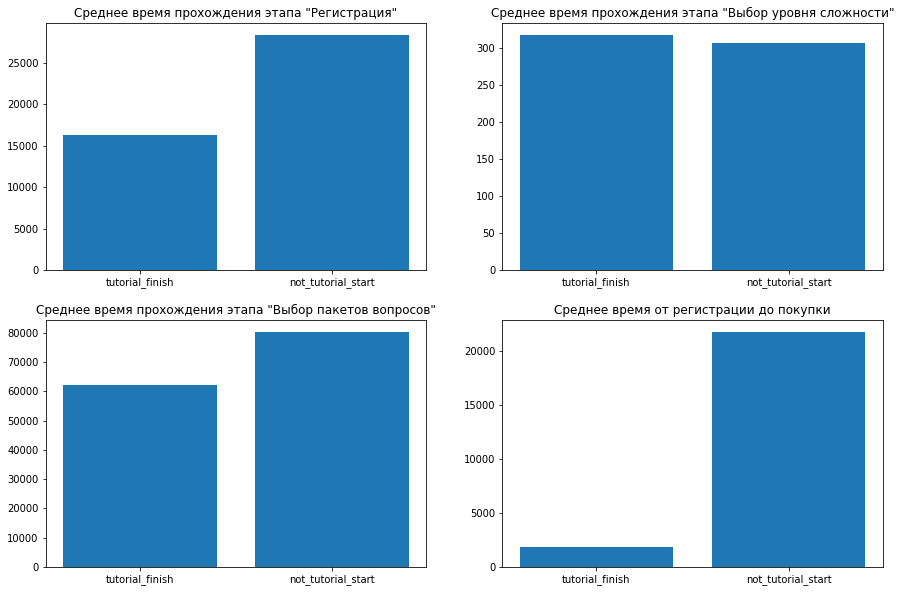

In [134]:
import matplotlib.pyplot as plt
import numpy as np

#визуализация систем координат
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axes[0][0].bar(x=average_timedelta_users['status'], 
            height=average_timedelta_users['registration'],
            label='Время в секундах')
axes[0][0].set_title('Среднее время прохождения этапа "Регистрация"')

axes[0][1].bar(x=average_timedelta_users['status'], 
            height=average_timedelta_users['level_choice'],
            label='Время в секундах')
axes[0][1].set_title('Среднее время прохождения этапа "Выбор уровня сложности"')

axes[1][0].bar(x=average_timedelta_users['status'], 
            height=average_timedelta_users['pack_choice'],
            label='Время в секундах')
axes[1][0].set_title('Среднее время прохождения этапа "Выбор пакетов вопросов"')

axes[1][1].bar(x=average_timedelta_users['status'], 
            height=average_timedelta_users['purchase'],
            label='Время в секундах')
axes[1][1].set_title('Среднее время от регистрации до покупки')

*Найдем разницу в показателях*

In [135]:
new_row = {'status':'difference', 
           'registration': abs(average_timedelta_users['registration'][0] - average_timedelta_users['registration'][1]), 
           'level_choice': abs(average_timedelta_users['level_choice'][0] - average_timedelta_users['level_choice'][1]), 
           'pack_choice': abs(average_timedelta_users['pack_choice'][0] - average_timedelta_users['pack_choice'][1]), 
           'purchase': abs(average_timedelta_users['purchase'][0] - average_timedelta_users['purchase'][1])}

average_timedelta_users = average_timedelta_users.append(new_row, ignore_index=True)

display(average_timedelta_users)

,status,registration,level_choice,pack_choice,purchase
0,tutorial_finish,16264,318,62279,1803
1,not_tutorial_start,28337,307,80410,21812
2,difference,12073,11,18131,20009


#### 2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

*Выделим группу пользователей, не проходивших обучение ни разу (не начинавших и начинавших, но не заканчивающих)*

In [136]:
amount_users_not_finished_tutorial = users_with_status_not_finished_tutorial_df["user_id"].nunique()

users_not_finished_tutorial_and_purchase_df = users_with_status_not_finished_tutorial_df.merge(purchase_df, on="user_id", how="inner")
amount_users_not_finished_tutorial_and_purchase = users_not_finished_tutorial_and_purchase_df["user_id"].nunique()

attempts_0 = pd.DataFrame(data = [[0, amount_users_not_finished_tutorial_and_purchase]], columns= ['count_attempts', 'count_users'])

*Остальный пользователей разобьем на группы по количеству прохождений обучения*

In [137]:
df = users_with_finished_tutorial_df[users_with_finished_tutorial_df["event_type"] == "tutorial_finish"]
df = df[["user_id", "tutorial_id"]]

users_finished_tutorial_and_purchase_df = df.merge(purchase_df, on="user_id", how="inner")
users_finished_tutorial_and_purchase_df = users_finished_tutorial_and_purchase_df[['user_id', 'tutorial_id']]

users_attempts = users_finished_tutorial_and_purchase_df.groupby(['user_id']).agg('nunique').reset_index()

attempts = users_attempts.groupby(['tutorial_id']).agg('nunique').reset_index()
attempts = attempts.rename(columns={"tutorial_id": "count_attempts", "user_id": "count_users"})

attempts = attempts_0.append(attempts, ignore_index=True)

display(attempts)

,count_attempts,count_users
0,0,153
1,1,1143
2,2,182
3,3,44
4,4,19
5,5,19
6,6,15
7,7,15
8,8,6
9,9,4


*Строим визуализацию с помощью библиотеки Matplotlib*

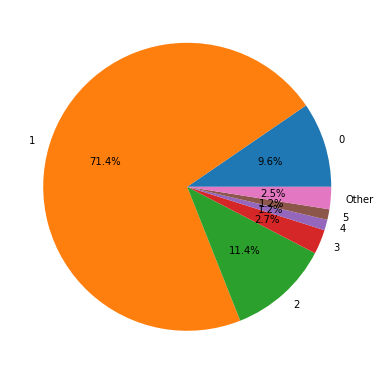

In [138]:
import matplotlib.pyplot as plt
import numpy as np

big_attempts = attempts[attempts['count_users'] > 16]
other_attempts = attempts[attempts['count_users'] < 16]
other_attempts_sums = pd.DataFrame(data = [['Other', other_attempts['count_users'].sum()]], columns= ['count_attempts', 'count_users'])
combinations_attempts = big_attempts.append(other_attempts_sums, ignore_index=True)

fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    combinations_attempts['count_users'],
    labels=combinations_attempts['count_attempts'],
    autopct='%.1f%%'
);

#### 3. Определить, насколько прозрачен процесс взаимодействия с игрой.

In [139]:
user_path_df = (total_events_df.groupby(["user_id"])["event_type"].apply(list).reset_index())

user_path_df["event_path"] = user_path_df["event_type"].apply(lambda x: " > ".join(x))

user_paths = (
    user_path_df.groupby(["event_path"])["user_id"]
    .nunique()
    .sort_values(ascending=False)
)

*Определим все возможные пути, когда после выбора уровня пользователь возвращался к обучению (начинал обучение) и посчитаем долю пользователей с такими путями от количества всех зарегистрированных пользователей*

In [140]:
user_paths_level_choice_tutorial_start = user_paths[user_paths.index.str.contains('level_choice > tutorial_start')]

user_paths_level_choice_tutorial_start_df = pd.DataFrame(user_paths_level_choice_tutorial_start)
count_user_paths_level_choice_tutorial_start = user_paths_level_choice_tutorial_start_df ['user_id'].sum()

registered_users_count = events_df[events_df["event_type"] == "registration"]["user_id"].nunique()

print(
    "Процент пользователей, начавших свое обучение после выбора уровня (от общего числа зарегистрировавшихся): {:.2%}".format(
        count_user_paths_level_choice_tutorial_start / registered_users_count
    )
)

Процент пользователей, начавших свое обучение после выбора уровня (от общего числа зарегистрировавшихся): 2.46%


### Выводы

**1. Определить, насколько обучение сокращает время прохождения этапов игры.**

Обучение не сокращается время прохождения этапов игры. Обучение влияет только на среднее время прохождения этапа "Выбор уровня сложности".

**2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.**

Доказано, что около 90% пользователей, купивших вопросы, успешно прошли обучение. И больше всего таких пользователей проходили обучение только один раз - 70% пользователей.

**3. Определить, насколько прозрачен процесс взаимодействия с игрой.**

Доказано, что порядок прохождения этапов игры понятен пользователям. Только 2,5% зарегистрированных пользователей вернулись к обучению после выбора уровня сложности.